# 7.4. Vários canais de entrada e vários canais de saída

Até agora, simplificamos todos os nossos exemplos numéricos trabalhando com apenas um único canal de entrada e um único canal de saída.  Isso nos permitiu pensar em nossas entradas, kernels de convolução e saídas, cada um como tensores bidimensionais (altura(h) x largura(w)).


Imagens RGB possuem 3 canais para indicar a quantidade de vermelho, verde e azul, um para cada cor, logo o tensor da imagem tem dimensão 3, formando um 'empilhamento' de 3 matrizes. Por exemplo, cada imagem de entrada RGB tem forma (3 x h x w). Nós nos referimos a esse eixo, com um tamanho de 3, como a dimensão do canal. 



# 7.4.1. Vários canais de entrada

Quando os dados de entrada contêm múltiplos canais, precisamos construir um kernel de convolução com o mesmo número de canais de entrada que os dados de entrada, para que ele possa executar correlação cruzada com os dados de entrada. 

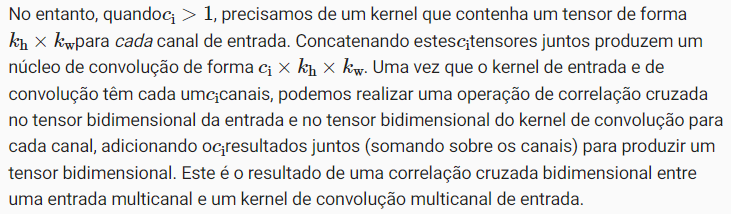

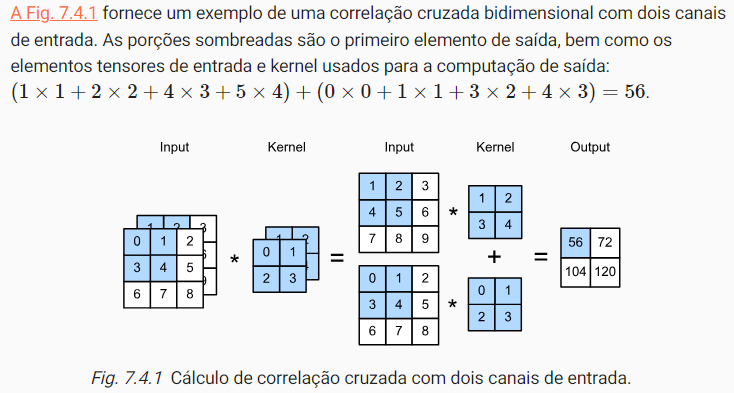

__Observe que tudo o que estamos fazendo é executar uma operação de correlação cruzada por canal e então somar os resultados.__

In [2]:
import torch
from d2l import torch as d2l


In [3]:
# Implementa operações de correlação cruzada com múltiplos canais de entrada nós mesmos.

def corr2d_multi_in(X, K):
    # Iterate through the 0th dimension (channel) of K first, then add them up
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))    # Realiza a CONVOLUÇÃO

# x = (1.0,2.0,3.0)
# k = (4.0,5.0,6.0)
# z = zip(x,k)
# print(tuple(z))    #out: ((1, 4), (2, 5), (3, 6))

In [5]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
print(X)
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])
print(K)

corr2d_multi_in(X, K)

tensor([[[0., 1., 2.],
         [3., 4., 5.],
         [6., 7., 8.]],

        [[1., 2., 3.],
         [4., 5., 6.],
         [7., 8., 9.]]])
tensor([[[0., 1.],
         [2., 3.]],

        [[1., 2.],
         [3., 4.]]])


tensor([[ 56.,  72.],
        [104., 120.]])

# 7.4.2. Vários canais de saída

Nas arquiteturas de rede neural mais populares, na verdade aumentamos a dimensão do canal à medida que nos aprofundamos na rede neural, normalmente reduzindo a amostragem para trocar a resolução espacial por maior profundidade do canal.

Intuitivamente, você pode pensar em cada canal como respondendo a um conjunto diferente de recursos. A realidade é um pouco mais complicada do que isso.

Em vez disso, os canais são otimizados para serem úteis em conjunto. 

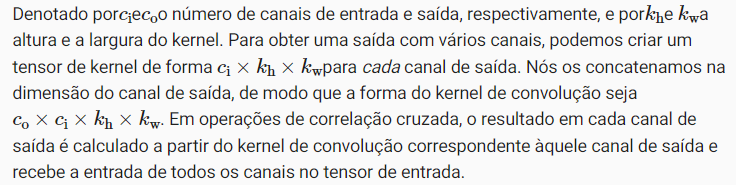



In [6]:
# Implementamos uma função de correlação cruzada para calcular a saída de vários canais, conforme mostrado abaixo.

def corr2d_multi_in_out(X, K):
    # Iterate through the 0th dimension of K, and each time, perform
    # cross-correlation operations with input X. All of the results are
    # stacked together
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)
    # torch.stack realiza o empilhamento de tensores

In [7]:
# Construímos um kernel de convolução trivial com três canais de saída concatenando o tensor do kernel para K com K+1 e K+2.
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [8]:
K

tensor([[[[0., 1.],
          [2., 3.]],

         [[1., 2.],
          [3., 4.]]],


        [[[1., 2.],
          [3., 4.]],

         [[2., 3.],
          [4., 5.]]],


        [[[2., 3.],
          [4., 5.]],

         [[3., 4.],
          [5., 6.]]]])

In [9]:
X

tensor([[[0., 1., 2.],
         [3., 4., 5.],
         [6., 7., 8.]],

        [[1., 2., 3.],
         [4., 5., 6.],
         [7., 8., 9.]]])

In [12]:
print(X.shape)
print(K.shape)

torch.Size([2, 3, 3])
torch.Size([3, 2, 2, 2])


In [10]:
# Realizamos operações de correlação cruzada no tensor de entrada X com o tensor kernel K.
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

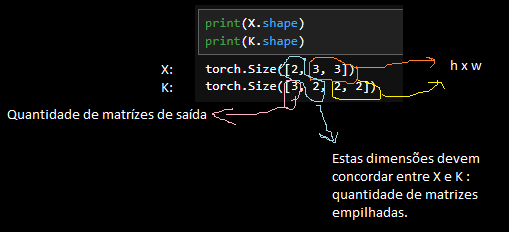

# 7.4.3.  Camada Convolucional 1 x 1

No início, uma convolução 1x1, ou seja,kh=kw=1, não parece fazer muito sentido.

Como a janela mínima é usada, a convolução 1x1 perde a capacidade de camadas convolucionais maiores de reconhecer padrões que consistem em interações entre elementos adjacentes nas dimensões de altura(h) e largura(w). O único cálculo da convolução 1x1 ocorre na dimensão do canal.

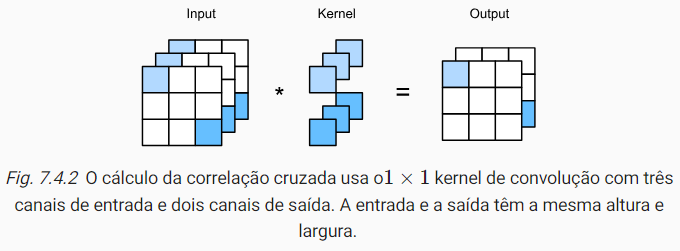

Vamos verificar se isso funciona na prática: implementamos uma convolução 1x1 usando uma camada totalmente conectada. A única coisa é que precisamos fazer alguns ajustes no formato dos dados antes e depois da multiplicação da matriz.




In [13]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape              # c_i é a quantidade de canais de entrada.
    c_o = K.shape[0]                 # quantidade de canais de saída.
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # Matrix multiplication in the fully connected layer
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

A função acima é equivalente à função de correlação cruzada implementada anteriormente corr2d_multi_in_out. 

In [43]:
X = torch.normal(mean=0, std=1, size=(3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6  # caso falso, aparece uma mensagem de erro: AssertionError
# verifica se o somatório das diferenças entre Y1 e Y2 é menor que 1e-6.

In [44]:
X

tensor([[[ 0.8395, -1.1636, -0.4626],
         [-1.3141,  0.9255,  0.5649],
         [ 1.3991,  0.1851, -0.1760]],

        [[ 0.1586, -0.7072, -0.9641],
         [ 0.2786, -0.1327, -2.5103],
         [-1.1172, -0.0127,  1.1648]],

        [[ 0.0090,  0.6727,  1.6181],
         [-0.7514,  1.2006, -1.1927],
         [ 2.8358,  1.2115,  0.3726]]])

tensor(0.1586)

In [45]:
X.shape

torch.Size([3, 3, 3])

In [46]:
K

tensor([[[[ 0.3477]],

         [[ 0.2942]],

         [[ 0.0211]]],


        [[[ 1.6587]],

         [[-0.2234]],

         [[ 0.2899]]]])

In [47]:
Y1

tensor([[[ 0.3388, -0.5985, -0.4104],
         [-0.3908,  0.3080, -0.5672],
         [ 0.2175,  0.0861,  0.2893]],

        [[ 1.3598, -1.5770, -0.0827],
         [-2.4598,  1.9128,  1.1520],
         [ 3.3924,  0.6611, -0.4441]]])

In [56]:
(X[0][0][0]*K[0][0][0]) + (X[1][0][0]*K[0][1][0]) + (X[2][0][0]*K[0][2][0])

tensor([0.3388])

In [57]:
Y2 = corr2d_multi_in_out(X, K)

In [58]:
Y2

tensor([[[ 0.3388, -0.5985, -0.4104],
         [-0.3908,  0.3080, -0.5672],
         [ 0.2175,  0.0861,  0.2893]],

        [[ 1.3598, -1.5770, -0.0827],
         [-2.4598,  1.9128,  1.1520],
         [ 3.3924,  0.6611, -0.4441]]])

In [59]:
float(torch.abs(Y1 - Y2).sum()) < 1e-6

True

In [60]:
torch.abs(Y1 - Y2).sum()

tensor(0.)

---------------------------------------------------------

In [66]:
c_i, h, w = X.shape              # c_i é a quantidade de canais de entrada.
c_o = K.shape[0]                 # quantidade de canais de saída.
X = X.reshape((c_i, h * w))
K = K.reshape((c_o, c_i))

In [67]:
X

tensor([[ 0.8395, -1.1636, -0.4626, -1.3141,  0.9255,  0.5649,  1.3991,  0.1851,
         -0.1760],
        [ 0.1586, -0.7072, -0.9641,  0.2786, -0.1327, -2.5103, -1.1172, -0.0127,
          1.1648],
        [ 0.0090,  0.6727,  1.6181, -0.7514,  1.2006, -1.1927,  2.8358,  1.2115,
          0.3726]])

In [68]:
K

tensor([[ 0.3477,  0.2942,  0.0211],
        [ 1.6587, -0.2234,  0.2899]])

Ou seja, a única coisa que precisamos fazer são alguns ajustes no formato dos dados antes e depois da multiplicação da matriz.

# Código Agrupado

In [114]:
import torch
from d2l import torch as d2l

# ------------------------------------------------------------------------------------------
# FUNÇÃO PARA CONVOLUÇÃO COM APENAS 1 ENTRADA E 1 SAÍDA: 
# Também está dentro da biblioteca d2l: d2l.corr2d
def corr2d(X, K):                                                   # Realiza a CONVOLUÇÃO
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()             # CONVOLUÇÃO
    return Y
# ------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------
# FUNÇÃO PARA CONVOLUÇÃO COM VÁRIAS ENTRADAS E APENAS 1 SAÍDA:
# Implementa operações de correlação cruzada com múltiplos canais de entrada nós mesmos.
def corr2d_multi_in(X, K):
    # Iterate through the 0th dimension (channel) of K first, then add them up
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))    # Realiza a CONVOLUÇÃO

# x = (1.0,2.0,3.0)
# k = (4.0,5.0,6.0)
# z = zip(x,k)
# print(tuple(z))    #out: ((1, 4), (2, 5), (3, 6))
# ------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------
# FUNÇÃO PARA CONVOLUÇÃO COM VÁRIAS ENTRADAS E VÁRIAS SAÍDAS:
# Implementamos uma função de correlação cruzada para calcular a saída de vários canais, conforme mostrado abaixo.
def corr2d_multi_in_out(X, K):
    # Iterate through the 0th dimension of K, and each time, perform
    # cross-correlation operations with input X. All of the results are
    # stacked together
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)
    # torch.stack realiza o empilhamento de tensores
# ------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------
# FUNÇÃO PARA CONVOLUÇÃO COM VÁRIAS ENTRADAS E VÁRIAS SAÍDAS COM KERNELS 1X1:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape              # c_i é a quantidade de canais de entrada.
    c_o = K.shape[0]                 # quantidade de canais de saída.
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # Matrix multiplication in the fully connected layer
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))
# ------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------
# DADOS:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])

K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])
# ------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------
# PARA 1 SAÍDA:
multi_in = corr2d_multi_in(X, K)
print(multi_in)
# ------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------
# PARA VÁRIAS SAÍDAS (3 SAÍDAS):
# Construímos um kernel de convolução trivial com três canais de saída concatenando o tensor do kernel para K com K+1 e K+2.
K1 = torch.stack((K, K + 1, K + 2), 0)    # torch.stack faz o empilhamento de tensores em um só tensor
K.shape

# Realizamos operações de correlação cruzada no tensor de entrada X com o tensor kernel K.
multi_in_out = corr2d_multi_in_out(X, K1)
print(multi_in_out)
# ------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------
# PARA NÚCLEOS 1X1:
K2 = torch.tensor([[[[ 0.0]],
         [[ 1.0]]],
        [[[ 1.0]],
         [[2.0]]]])

multi_in_out1 = corr2d_multi_in_out(X, K2)
print(multi_in_out1)
multi_in_out_1x1 = corr2d_multi_in_out_1x1(X, K2)
print(multi_in_out_1x1)
print(multi_in_out1 == multi_in_out_1x1)

tensor([[ 56.,  72.],
        [104., 120.]])
tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])
tensor([[[ 1.,  2.,  3.],
         [ 4.,  5.,  6.],
         [ 7.,  8.,  9.]],

        [[ 2.,  5.,  8.],
         [11., 14., 17.],
         [20., 23., 26.]]])
tensor([[[ 1.,  2.,  3.],
         [ 4.,  5.,  6.],
         [ 7.,  8.,  9.]],

        [[ 2.,  5.,  8.],
         [11., 14., 17.],
         [20., 23., 26.]]])
tensor([[[True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True]]])


# 7.4.4. Discussão

Em particular, os canais permitem que a CNN raciocine com vários recursos, como detectores de borda e forma ao mesmo tempo. Eles também oferecem um trade-off prático entre a redução drástica de parâmetros decorrente da invariância de tradução e localidade, e a necessidade de modelos expressivos e diversos em visão computacional.

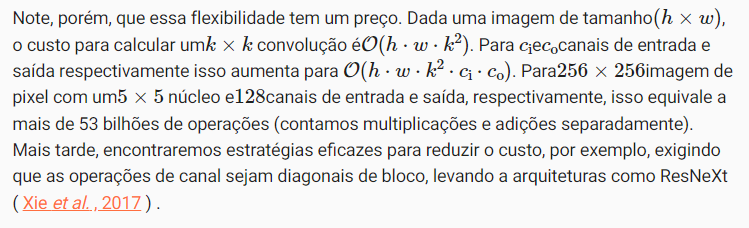



# 

# Shape

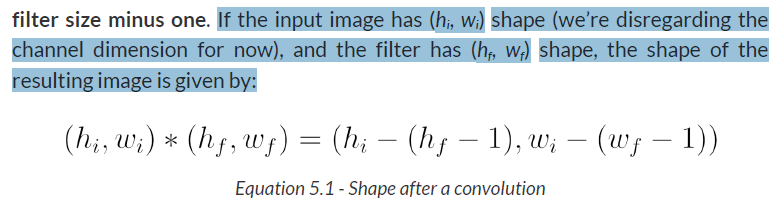

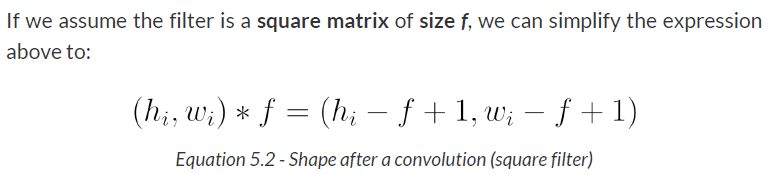

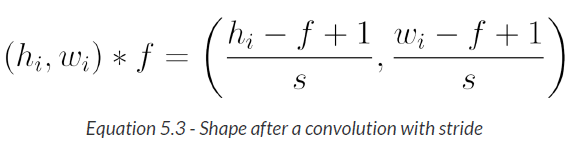

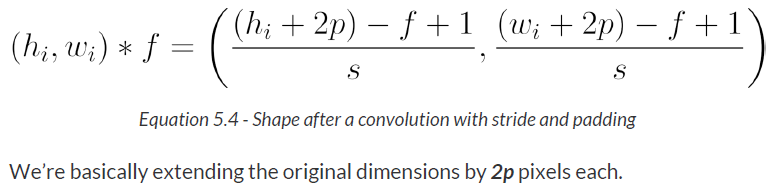



# Custo computacional para o Foward propagation

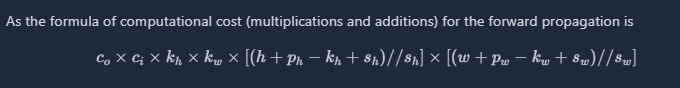

# 7.4.5. Exercícios

# Ex. 1 - Suponha que temos dois kernels de convolução de tamanho k1 e k2, respectivamente (sem não linearidade entre eles).
- Prove que o resultado da operação pode ser expresso por uma única convolução.
- Qual é a dimensionalidade da convolução única equivalente?
- O inverso é verdadeiro, ou seja, você sempre pode decompor uma convolução em duas menores?

- Prove que o resultado da operação pode ser expresso por uma única convolução.

Combining two convolution kernels:



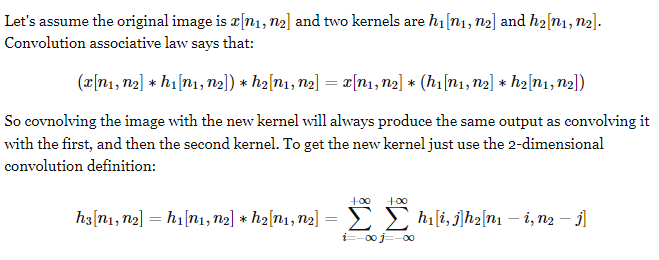



In [115]:
# TENTEI FAZER MAS OS RESULTADOS NÃO ESTÃO BATENDO:

import torch
from d2l import torch as d2l

X1 = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K1 = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
K2 = K1+1

# C2 = (X1*K1)*K2
C1 = d2l.corr2d(X1, K1)
C2 = d2l.corr2d(C1, K2)

# C3 = X1*(K1*K2)
K = d2l.corr2d(K1, K2)
C3 = d2l.corr2d(X1, K)

# C2==C3



In [116]:
print(C2)

tensor([[352.]])


In [117]:
print(C3)

tensor([[  0.,  20.,  40.],
        [ 60.,  80., 100.],
        [120., 140., 160.]])


In [118]:
print(C3.sum())

tensor(720.)


Mas a pergunta não foi bem essa. Não é sobre a ordem de convoluções mas sim de uma convolução única.

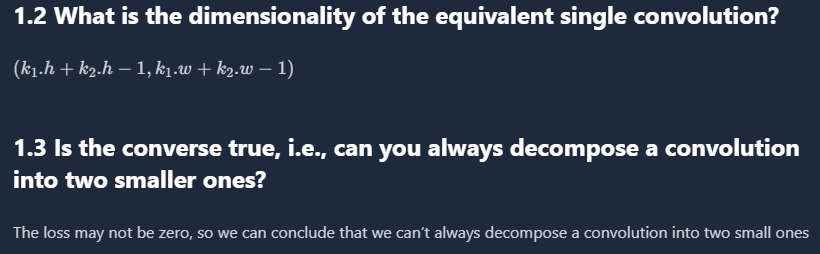

# Ex. 4 - As variáveis Y1 e Y2 no exemplo final desta seção são exatamente as mesmas? Por quê?

In [125]:
import torch


def corr2d_multi_in_out(X, K):
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape              # c_i é a quantidade de canais de entrada.
    c_o = K.shape[0]                 # quantidade de canais de saída.
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # Matrix multiplication in the fully connected layer
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))



X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
float(torch.abs(Y1 - Y2).sum()) < 1e-330

False

Não são exatamente iguais. Diferem a partir de uma ordem de grandeza de 1e-330

# Outras respostas:

https://pandalab.me/archives/multiple_input_and_multiple_output_channels

# Referências

https://math.stackexchange.com/questions/1023984/combining-two-convolution-kernels